# Gradient Boosting Classifier

In [335]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
import pickle
import sys
import joblib
import os

IMAGE_SIZE = [32, 32]

In [333]:
df = pd.read_json('../data/labelled_data/whole_data_1637521796.json', orient='records')

In [301]:
# Show amount of samples
print("amount of samples:", df.shape[0])
df.head(n=3)

amount of samples: 200


,index,Timestamp,Sensor ID,Room Temperature,RSSI,data,changed,label
521,521,2021-05-07 13:06:24,3078,21.299999,-67,"[[12.0, 10.4, 11.1, 10.9, 10.9, 12.0, 11.6, 11...",True,Human
2940,2940,2021-05-07 13:10:22,3078,22.400000,-76,"[[11.8, 10.3, 11.2, 11.8, 10.6, 11.3, 11.4, 11...",True,Human
226,226,2021-05-07 13:05:55,3078,21.100000,-68,"[[11.5, 10.5, 12.0, 12.5, 12.6, 13.0, 12.6, 12...",True,Ambigous heat


In [302]:
# convert labels
binary_label_converter = { 
    'Human': 1,
    'Several humans': 1, 
    'Non-human heat': 0, 
    'Ambigous heat': 0,
    'No heat':  0,
}


df_binary = df.copy()

df_binary['label'] = df['label'].apply(lambda x: binary_label_converter[x])
df_binary.head(n=3)

,index,Timestamp,Sensor ID,Room Temperature,RSSI,data,changed,label
521,521,2021-05-07 13:06:24,3078,21.299999,-67,"[[12.0, 10.4, 11.1, 10.9, 10.9, 12.0, 11.6, 11...",True,1
2940,2940,2021-05-07 13:10:22,3078,22.400000,-76,"[[11.8, 10.3, 11.2, 11.8, 10.6, 11.3, 11.4, 11...",True,1
226,226,2021-05-07 13:05:55,3078,21.100000,-68,"[[11.5, 10.5, 12.0, 12.5, 12.6, 13.0, 12.6, 12...",True,0


In [303]:
# Prepare the data
y = df_binary['label'].to_numpy()
X = np.array(df_binary['data'].to_list())
X = np.expand_dims(X, axis=3)
print(y.shape)
print(X.shape)

(200,)
(200, 32, 32, 1)


In [304]:
# Create train / val / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.25, random_state=0)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(y_train[:1])

(180, 32, 32, 1)
(180,)
(15, 32, 32, 1)
(15,)
[0]


In [305]:
# Squeezenet Model

bnmomemtum=0.9

def fire(x, squeeze, expand):
    y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
    y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
    y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
    y1 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y1)
    y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
    y3 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y3)
    return tf.keras.layers.concatenate([y1, y3])

def fire_module(squeeze, expand):
    return lambda x: fire(x, squeeze, expand)

x = tf.keras.layers.Input(shape=[*IMAGE_SIZE,1]) # input is 32x32 pixels RGB
y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', use_bias=True, activation='relu')(x)
y = tf.keras.layers.GlobalAveragePooling2D()(y)
y = tf.keras.layers.Dense(64)(y)
y = tf.keras.layers.Dense(32)(y)
y = tf.keras.layers.Dropout(0.2)(y)
y = tf.keras.layers.Dense(2, activation='softmax')(y)

model = tf.keras.Model(x, y)

In [306]:
model.compile(
optimizer='adam',
loss= 'sparse_categorical_crossentropy',
metrics=['accuracy'])
model.build(input_shape=(None, 32, 32, 1))
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_79 (Conv2D)          (None, 32, 32, 32)        320       
                                                                 
 global_average_pooling2d_3   (None, 32)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_69 (Dense)            (None, 64)                2112      
                                                                 
 dense_70 (Dense)            (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                           

In [307]:
# Plot the model
# `rankdir='LR'` is to make the graph horizontal.
%matplotlib inline
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


Epoch 1/30
12/12 [==============================] - 1s 23ms/step - loss: 0.8645 - accuracy: 0.5167 - val_loss: 0.6764 - val_accuracy: 0.6000
Epoch 2/30
12/12 [==============================] - 0s 14ms/step - loss: 0.8194 - accuracy: 0.5222 - val_loss: 0.6809 - val_accuracy: 0.6000
Epoch 3/30
12/12 [==============================] - 0s 14ms/step - loss: 0.8069 - accuracy: 0.5722 - val_loss: 0.7082 - val_accuracy: 0.4000
Epoch 4/30
12/12 [==============================] - 0s 18ms/step - loss: 0.7358 - accuracy: 0.5778 - val_loss: 0.6783 - val_accuracy: 0.6000
Epoch 5/30
12/12 [==============================] - 0s 10ms/step - loss: 0.6682 - accuracy: 0.5944 - val_loss: 0.6793 - val_accuracy: 0.6000
Epoch 6/30
12/12 [==============================] - 0s 10ms/step - loss: 0.7123 - accuracy: 0.5889 - val_loss: 0.6874 - val_accuracy: 0.6000
Epoch 7/30
12/12 [==============================] - 0s 10ms/step - loss: 0.7253 - accuracy: 0.5222 - val_loss: 0.7114 - val_accuracy: 0.6000
Epoch 8/30
12

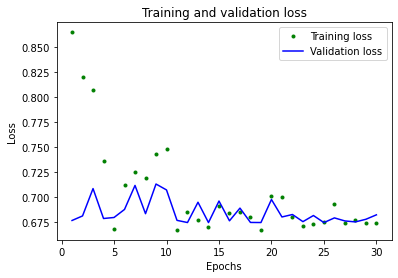

In [308]:
# Fit the model
EPOCHS = 30
BATCH_SIZE = 16
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))


train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Plot training history
plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [309]:
def get_feature_map_list(model):
    
    feature_map_list = []
        
    for i in range(len(model.layers)):
        layer = model.layers[i]
        # check for convolutional layer
        if 'conv' not in layer.name:
            continue
        # summarize output shape
        print(i, layer.name, layer.output.shape)
        
        # Get the layer input and output
        if i==0:
            inputs = model.inputs
        else:
            inputs = model.layers[i-1].input
            
        if i==len(model.layers):
            outputs = model.outputs
        else:
            outputs = model.layers[i].output
        
        current_feature_map = tf.keras.Model(name=layer.name, inputs=inputs, outputs=model.layers[i].output)
        feature_map_list.append(current_feature_map)
    
    return feature_map_list
        
    
    

In [369]:
layer_list = get_feature_map_list(model)
print(layer_list)

for i in range(len(layer_list)):
    layer_list[i].save(f"layer_{i}")

1 conv2d_79 (None, 32, 32, 32)
INFO:tensorflow:Assets written to: layer_0\assets


In [350]:
# Calculate the feature map mean
feature_map_mean_list = []

# Print the shape of the feature maps
for i in range(len(layer_list)):
    feature_map = layer_list[i].predict(X)
    feature_map_mean = np.mean(feature_map, axis=(1,2))
    feature_map_mean_list.append(feature_map_mean)
    
feature_map_means = np.concatenate(feature_map_mean_list, axis=1)
print(feature_map_means.shape)
print(feature_map_means[:1])

(200, 32)
[[1.39346254e+00 4.05337048e+00 8.64487782e-04 2.13232398e+00
  0.00000000e+00 0.00000000e+00 2.08923674e+00 4.85774055e-02
  2.48878026e+00 4.51544702e-01 7.20588863e-01 2.06344628e+00
  1.05363965e-01 4.84903052e-04 6.96679875e-02 1.19036067e+00
  0.00000000e+00 5.54429531e-01 2.62184218e-02 3.38546210e-03
  1.39833212e+00 4.77462716e-04 0.00000000e+00 1.64833450e+00
  2.35785507e-02 5.50622120e-04 0.00000000e+00 1.05777597e-02
  5.22362888e-02 9.14172851e-05 0.00000000e+00 9.61532772e-01]]


In [351]:
df_train_binary_expanded = pd.DataFrame(np.concatenate([df_binary.head(X.shape[0]), feature_map_means], axis=1))

In [353]:
df_train_binary_expanded.head(n=2)

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,521,2021-05-07 13:06:24,3078,21.299999,-67,"[[12.0, 10.4, 11.1, 10.9, 10.9, 12.0, 11.6, 11...",True,1,1.393463,4.05337,...,0.0,1.648335,0.023579,0.000551,0.0,0.010578,0.052236,0.000091,0.0,0.961533
1,2940,2021-05-07 13:10:22,3078,22.4,-76,"[[11.8, 10.3, 11.2, 11.8, 10.6, 11.3, 11.4, 11...",True,1,1.381259,4.012577,...,0.0,1.628707,0.022878,0.001053,0.0,0.008351,0.05199,0.00004,0.0,0.958451


In [354]:
# Prepare the data for gradient boosting
y_clf = df_train_binary_expanded[7].to_numpy().astype(int)
X_clf= df_train_binary_expanded.iloc[:,8:].to_numpy()
print(y_clf.shape)
print(X_clf.shape)

(200,)
(200, 32)


In [355]:
# Create train / val / test split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=0)

print(X_train_clf.shape)
print(y_train_clf.shape)
print(X_test_clf.shape)
print(y_test_clf.shape)
print(y_train_clf[:1])

(160, 32)
(160,)
(40, 32)
(40,)
[0]


In [367]:
# Train the GBT
clf = GradientBoostingClassifier(n_estimators=60, learning_rate=1.0, max_depth=3, random_state=0).fit(X_train_clf, y_train_clf)

# Mean accuracy
clf.score(X_test_clf, y_test_clf)

0.725

In [374]:
# Get the model size in kiB
fname = "clf"
joblib.dump(clf, fname)
model_size = os.path.getsize(fname)
model_size = model_size / 1024
print(f"GBT size in kiB: {model_size}")

# Get the conv layers size in kiB
layer_size = 0
for i in range(len(layer_list)):
    layer_size = os.path.getsize(f"layer_{i}")
layer_size = layer_size / 1024
print(f"Conv layer size in kiB: {layer_size}")

# Total size for GBT in kiB
print(f"Total size in kiB: {layer_size + model_size}")

GBT size in kiB: 99.326171875
Conv layer size in kiB: 4.0
Total size in kiB: 103.326171875


4.0


103.326171875
